In [10]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)
from libs.common import *
from config.config import *

c:\Users\Admin\Data\ads_fraud_detection


In [11]:
save_dir=f"{exps_dir}/exp2/exp_nosmote"

save_dir = f"{save_dir}"
os.makedirs(save_dir, exist_ok=True)
test_size=0.33
seed=42

In [12]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{save_dir}/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

(19430, 34) (19430, 1) (5089, 34) (5089, 1)


{0: 0.5317035512094699, 1: 8.385551948051948}

In [13]:
def oneHot(arr):
    labels = np.array(arr)
    encoder = OneHotEncoder(sparse=False)
    
    labels_reshaped = labels.reshape(-1, 1)
    
    encoder.fit(labels_reshaped)
    
    onehot_labels = encoder.transform(labels_reshaped)
    # onehot_labels=pd.DataFrame(onehot_labels)
    return onehot_labels

# y_train_onehot=oneHot(y_train)
# y_test_onehot=oneHot(y_test)
# print(y_test_onehot.shape,y_train_onehot.shape)


In [14]:
y_train_onehot=pd.DataFrame(oneHot(y_train))
y_test_onehot=pd.DataFrame(oneHot(y_test))
y_train_onehot.to_excel(f'{save_dir}/y_train_onehot.xlsx', index=False)
y_test_onehot.to_excel(f'{save_dir}/y_test_onehot.xlsx', index=False)
print(y_test_onehot.shape,y_train_onehot.shape)

(5089, 2) (19430, 2)


In [15]:
print(y_train_onehot.value_counts())
print(y_test_onehot.value_counts())

0    1  
0.0  1.0    9715
1.0  0.0    9715
Name: count, dtype: int64
0    1  
1.0  0.0    4782
0.0  1.0     307
Name: count, dtype: int64


In [16]:
feature_selection=dict(np.load(f'{save_dir}/feature_model_selection.npz',allow_pickle=True))['feature_model_selection']
feature_selection = {key: value for key, value in feature_selection.item().items()}
feature_selection.keys()

dict_keys(['LR', 'LDA', 'DTC', 'RD', 'KNC', 'GNB', 'NN', 'BG', 'NB', 'SVM'])

### Kết luận:
- Nhóm xây dựng một mạng Netual network ứng dụng kỹ thuật trong học sâu như callbacks, đánh trọng số,.... Nhưng không khắc phục được tình trạng (imbalanced variable).

# 6. Đánh giá và lựa chọn mô hình học máy có giám sát

In [8]:
def check_model(name,model,X,Y,names,results,scoring):
    kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
    cv_results=cross_val_score(model,X[feature_selection[name]],Y,cv=kfold,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg=scoring.title()+" %s: %.3f%% (%.3f%%)"%(name,cv_results.mean()*100,cv_results.std()*100)
    print(msg)       
    return 

In [9]:
num_folds=5
seed=7
models=[]

models.append(('KNC',KNeighborsClassifier(n_neighbors=100)))
models.append(('NB',GaussianNB()))
models.append(('SVM',SVC(class_weight=class_weights_dict)))
models.append(('NN',MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)))
models.append(('GD',GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)))
#models.append(('Naive',MultinomialNB()))


RandomForestClassifier(n_estimators=500, 
                                max_depth=10, 
                                min_samples_split=400, 
                                random_state=12, 
                                class_weight=class_weights_dict,
                                )

results=[]
names=[]
scorings=['accuracy','precision','recall','f1']
#check_model('LR',LogisticRegression(class_weight=class_weights_dict),X_logistic,Y,names,results,scorings)
#check_model('LDA',LinearDiscriminantAnalysis(),X_linear,Y,names,results,scorings)
#check_model('CART',DecisionTreeClassifier(class_weight=class_weights_dict),X_decision,Y,names,results,scorings)
#check_model('RD',RandomForestClassifier(n_estimators=100, random_state=42,class_weight=class_weights_dict),X_forest,Y,names,results,scorings)



for scoring in scorings:
    check_model('LR', LogisticRegression(class_weight=class_weights_dict, random_state=seed), x_train, y_train, names, results, scoring)
    check_model('LDA', LinearDiscriminantAnalysis(), x_train, y_train, names, results, scoring)
    check_model('DTC', DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=4, class_weight=class_weights_dict, random_state=seed), x_train, y_train, names, results, scoring)
    check_model('RD', RandomForestClassifier(n_estimators=100, random_state=seed, class_weight=class_weights_dict), x_train, y_train, names, results, scoring)
    check_model('KNC', KNeighborsClassifier(n_neighbors=100), x_train, y_train, names, results, scoring)
    check_model('NB', GaussianNB(), x_train, y_train, names, results, scoring)
    check_model('SVM', SVC(kernel='rbf', gamma='scale' ,class_weight=class_weights_dict, random_state=seed), x_train, y_train, names, results, scoring)
    check_model('NN', MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=seed), x_train, y_train, names, results, scoring)
    check_model('BG', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=seed), x_train, y_train, names, results, scoring)
    check_model('LGBM', LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=-1, random_state=seed), x_train, y_train, names, results, scoring)
    check_model('XGB', XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=seed, use_label_encoder=False, eval_metric='mlogloss'), x_train, y_train, names, results, scoring)
    
    # Vẽ biểu đồ
    fig = plt.figure()
    fig.suptitle(f'So sánh tương quan {scoring.title()} các loại mô hình')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()
    
    results = []
    names = []
    # fig=plt.figure()
    # fig.suptitle(f'So sánh tương quan {scoring.title()} các loại mô hình')
    # ax=fig.add_subplot(111)
    # plt.boxplot(results)
    # ax.set_xticklabels(names)
    # plt.show()
    # results=[]
    # names=[]


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Admin\Data\ads_fraud_detection\.conda\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Admin\Data\ads_fraud_detection\.conda\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Admin\Data\ads_fraud_detection\.conda\lib\site-packages\sklearn\linear_model\_logistic.py", line 1208, in fit
    X, y = self._validate_data(
  File "c:\Users\Admin\Data\ads_fraud_detection\.conda\lib\site-packages\sklearn\base.py", line 622, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\Admin\Data\ads_fraud_detection\.conda\lib\site-packages\sklearn\utils\validation.py", line 1162, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
  File "c:\Users\Admin\Data\ads_fraud_detection\.conda\lib\site-packages\sklearn\utils\validation.py", line 1183, in _check_y
    y = column_or_1d(y, warn=True)
  File "c:\Users\Admin\Data\ads_fraud_detection\.conda\lib\site-packages\sklearn\utils\validation.py", line 1244, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (15544, 2) instead.


Accuracy LR: 61.663% (1.701%)
Accuracy LDA: 93.928% (0.610%)
Accuracy DTC: 62.586% (0.832%)
Accuracy RD: 93.987% (0.690%)
Accuracy KNC: 93.967% (0.647%)
Accuracy NB: 91.393% (0.148%)
Accuracy SVM: 60.896% (1.577%)
Accuracy NN: 93.555% (0.782%)
Accuracy BG: 93.908% (0.651%)


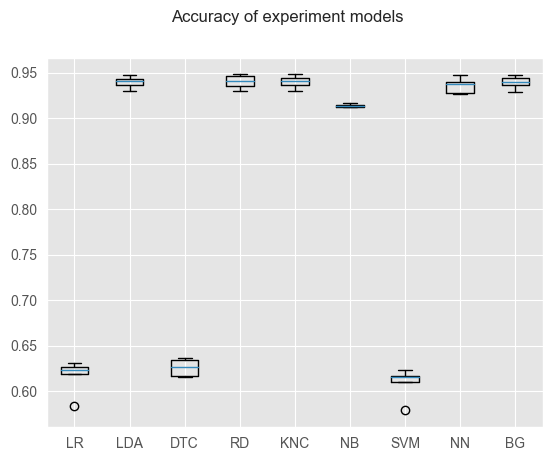

Precision LR: 12.691% (1.418%)
Precision LDA: 13.333% (16.330%)
Precision DTC: 12.542% (1.726%)
Precision RD: 51.389% (5.958%)
Precision KNC: 0.000% (0.000%)
Precision NB: 17.491% (4.391%)
Precision SVM: 12.531% (1.470%)
Precision NN: 8.000% (16.000%)
Precision BG: 0.000% (0.000%)


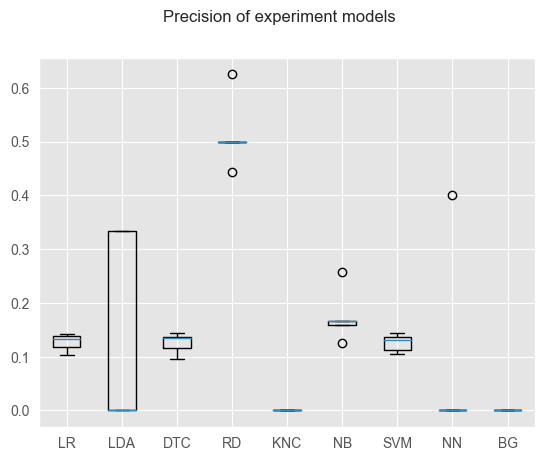

Recall LR: 91.065% (5.440%)
Recall LDA: 0.728% (0.893%)
Recall DTC: 87.265% (9.373%)
Recall RD: 5.617% (1.874%)
Recall KNC: 0.000% (0.000%)
Recall NB: 11.092% (1.751%)
Recall SVM: 91.538% (3.625%)
Recall NN: 0.755% (1.509%)
Recall BG: 0.000% (0.000%)


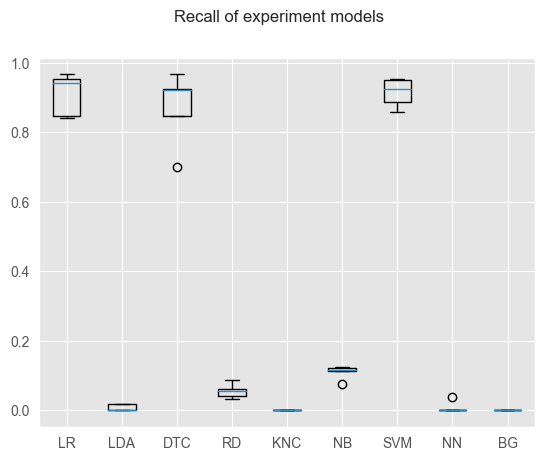

F1 LR: 22.248% (2.235%)
F1 LDA: 1.381% (1.693%)
F1 DTC: 21.906% (2.835%)
F1 RD: 10.061% (3.132%)
F1 KNC: 0.000% (0.000%)
F1 NB: 13.363% (2.126%)
F1 SVM: 22.017% (2.319%)
F1 NN: 1.379% (2.759%)
F1 BG: 0.000% (0.000%)


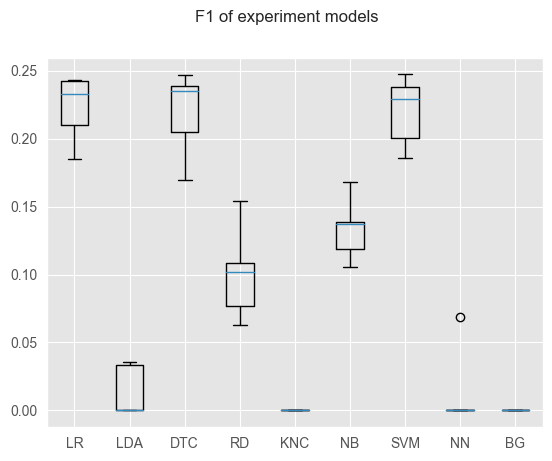

In [8]:
# for scoring in scorings:
#     check_model('LR', LogisticRegression(class_weight=class_weights_dict, random_state=seed), x_test, y_test, names, results, scoring)
#     check_model('LDA', LinearDiscriminantAnalysis(), x_test, y_test, names, results, scoring)
#     check_model('DTC', DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=4, class_weight=class_weights_dict, random_state=seed), x_test, y_test, names, results, scoring)
#     check_model('RD', RandomForestClassifier(n_estimators=100, random_state=seed, class_weight=class_weights_dict), x_test, y_test, names, results, scoring)
#     check_model('KNC', KNeighborsClassifier(n_neighbors=100), x_test, y_test, names, results, scoring)
#     check_model('NB', GaussianNB(), x_test, y_test, names, results, scoring)
#     check_model('SVM', SVC(kernel='rbf', gamma='scale' ,class_weight=class_weights_dict, random_state=seed), x_test, y_test, names, results, scoring)
#     check_model('NN', MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=seed), x_test, y_test, names, results, scoring)
#     check_model('BG', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=seed), x_test, y_test, names, results, scoring)
#     fig=plt.figure()
#     fig.suptitle(f'{scoring.title()} of experiment models')
#     ax=fig.add_subplot(111)
#     plt.boxplot(results)
#     ax.set_xticklabels(names)
#     # plt.savefig(f'So sánh tương quan {scoring.title()} các loại mô hình.png')
#     plt.show()
#     results=[]
#     names=[]

In [9]:
names = [
    'LR',
    'LDA',
    'DTC',
    'RD',
    'KNC',
    'NB',
    'SVM',
    'NN',
    'BG',
    'LGBM',  # Thêm mô hình LightGBM
    'XGB'    # Thêm mô hình XGBoost
]

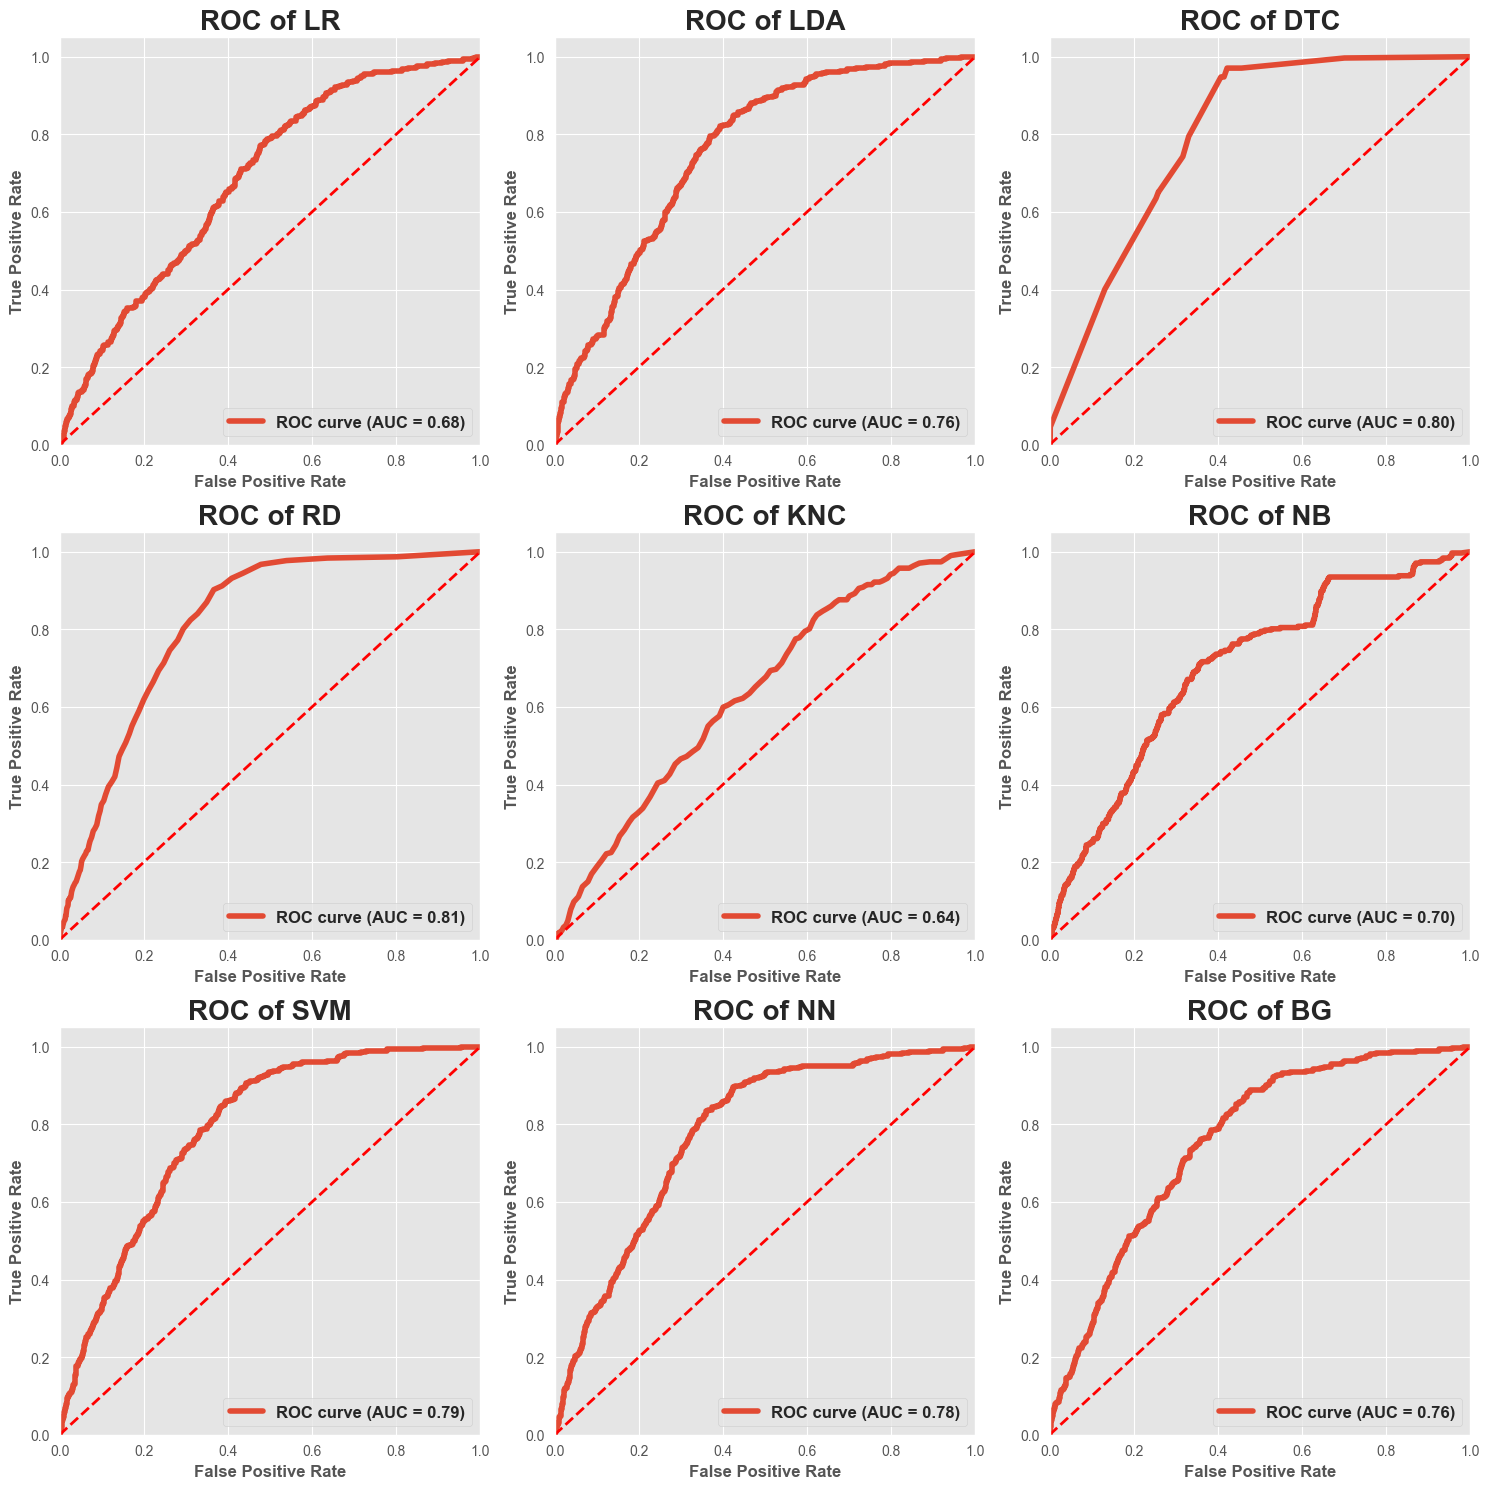

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, name, X_test, y_test, ax):
    model.fit(x_train,y_train)
    try:
        # Huấn luyện mô hình trên dữ liệu huấn luyện
        y_scores = model.predict_proba(X_test)[:,1]
    except:
        y_scores = model.decision_function(X_test)
    
    # Tính toán FPR và TPR từ decision function
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    
    # Tính diện tích dưới đường cong ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Vẽ đường cong ROC
    ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  # Đặt kích thước và độ dày cho nhãn trục x
    ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   # Đặt kích thước và độ dày cho nhãn trục y
    ax.set_title(f'ROC of {name}',fontsize=20, weight='bold')  # Đặt kích thước và độ dày cho tiêu đề
    ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})  # Đặt kích thước và độ dày cho chú thích
        

# Tạo một lưới đồ thị 3x3
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
models = [
    LogisticRegression(class_weight='balanced', random_state=seed),
    LinearDiscriminantAnalysis(),
    DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=4, class_weight='balanced', random_state=seed),
    RandomForestClassifier(n_estimators=100, random_state=seed, class_weight='balanced'),
    KNeighborsClassifier(n_neighbors=100),
    GaussianNB(),
    SVC(kernel='rbf', gamma='scale', class_weight='balanced', random_state=seed),
    MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=seed),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42),
    LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=-1, random_state=seed),  # Mô hình LightGBM
    XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=seed, use_label_encoder=False, eval_metric='mlogloss')  # Mô hình XGBoost
]# Lặp qua từng mô hình và vẽ đường cong ROC
for i, model in enumerate(models):
    name=names[i]
    row = i // 3
    col = i % 3
    plot_roc_curve(model,name , x_test, y_test, ax=axes[row, col])

# Cân chỉnh khoảng cách giữa các subplot
plt.tight_layout()

# Hiển thị đồ thị
plt.show()


In [17]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

def train_model(best_model, x_train, y_train, features):
    x = x_train[features]
    for train_index, _ in kfold.split(x):
        X_train_fold, y_train_fold = x_train.iloc[train_index][features], y_train.iloc[train_index]
        
        # Huấn luyện mô hình tốt nhất trên fold hiện tại
        best_model.fit(X_train_fold, y_train_fold)
    return best_model


In [19]:
print(class_weights_dict)
n_classes = y_train_onehot.shape[1]
class_weights_dict = {i: class_weights_dict[i] for i in range(len(class_weights_dict))}
class_weights_onehot = np.eye(n_classes)
for i, weight in class_weights_dict.items():
    class_weights_onehot[i] *= weight

print("Trọng số dưới dạng one-hot encoding:\n", class_weights_onehot)

{0: 0.5317035512094699, 1: 8.385551948051948}
Trọng số dưới dạng one-hot encoding:
 [[0.53170355 0.        ]
 [0.         8.38555195]]


In [21]:
class_weights_dict1 = {i: class_weights_onehot[i].tolist() for i in range(len(class_weights_onehot))}
class_weights_dict1

{0: [0.5317035512094699, 0.0], 1: [0.0, 8.385551948051948]}

In [23]:
n_classes = y_train_onehot.shape[1]

# Tạo danh sách từ điển cho class_weight
class_weights_list = [{i: class_weights_dict[i]} for i in range(n_classes)]

In [24]:
class_weights_list

[{0: 0.5317035512094699}, {1: 8.385551948051948}]

#### Build and evaluate model

In [ ]:
from sklearn.multioutput import MultiOutputClassifier


In [28]:
best_model1 = train_model(RandomForestClassifier(n_estimators=100, random_state=seed, class_weight= 'balanced'),x_train=x_train,y_train=y_train,features=feature_selection['RD'])
best_model2=train_model(GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=seed),x_train=x_train,y_train=y_train,features=feature_selection['BG'])
best_model3=train_model(SVC(kernel='rbf', gamma='scale' ,class_weight= 'balanced', random_state=seed),x_train=x_train,y_train=y_train,features=feature_selection['SVM'])


In [29]:
evaluate_result={}

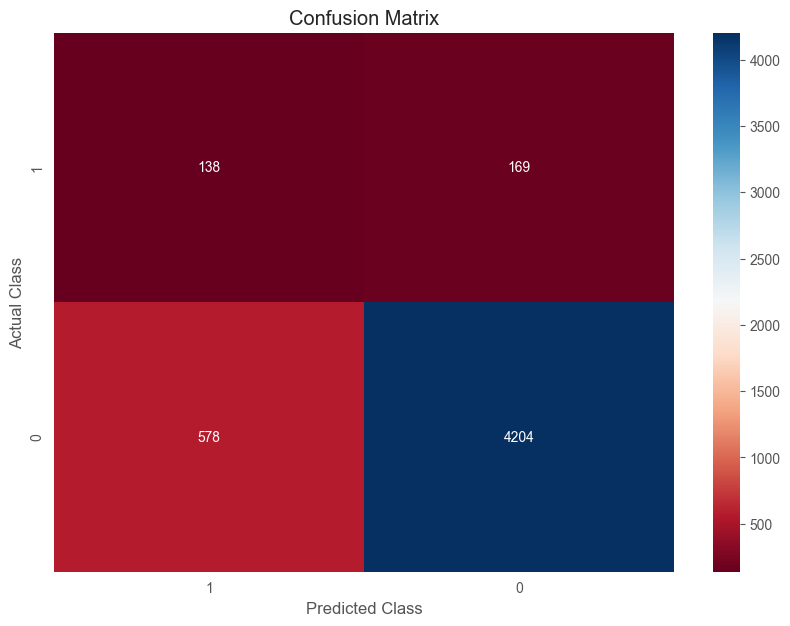

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      4782
           1       0.19      0.45      0.27       307

    accuracy                           0.85      5089
   macro avg       0.58      0.66      0.59      5089
weighted avg       0.91      0.85      0.88      5089



In [30]:
predictions = best_model1.predict(x_test[feature_selection['RD']])

conf_matrix = confusion_matrix(y_test, predictions,labels=[1,0])

# Vẽ heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=['1', '0'], yticklabels=['1', '0'],cmap='RdBu')
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()
evaluate_result['RD']=classification_report(y_test, predictions)

print(classification_report(y_test, predictions))

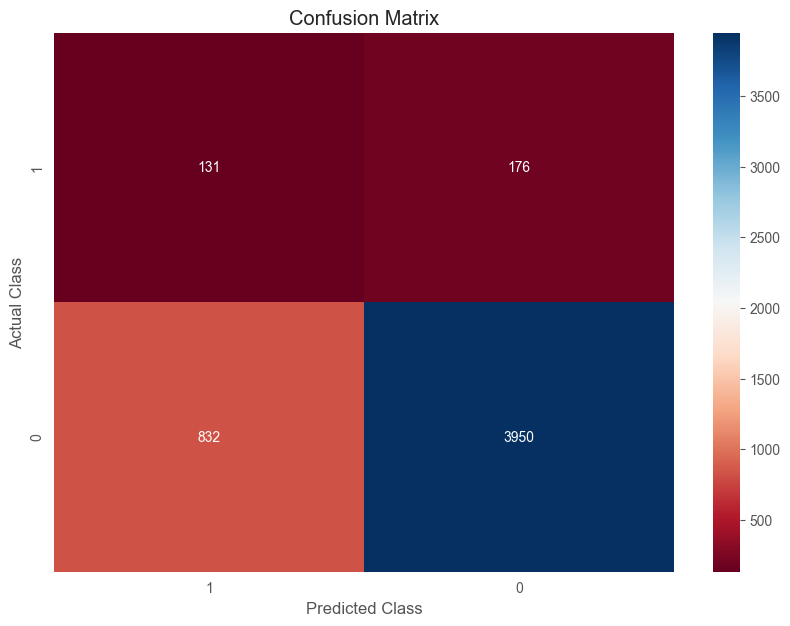

              precision    recall  f1-score   support

           0       0.96      0.83      0.89      4782
           1       0.14      0.43      0.21       307

    accuracy                           0.80      5089
   macro avg       0.55      0.63      0.55      5089
weighted avg       0.91      0.80      0.85      5089



In [31]:
predictions = best_model2.predict(x_test[feature_selection['BG']])

conf_matrix = confusion_matrix(y_test, predictions,labels=[1,0])

# Vẽ heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=['1', '0'], yticklabels=['1', '0'],cmap='RdBu')
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()
evaluate_result['BG']=classification_report(y_test, predictions)
print(classification_report(y_test, predictions))

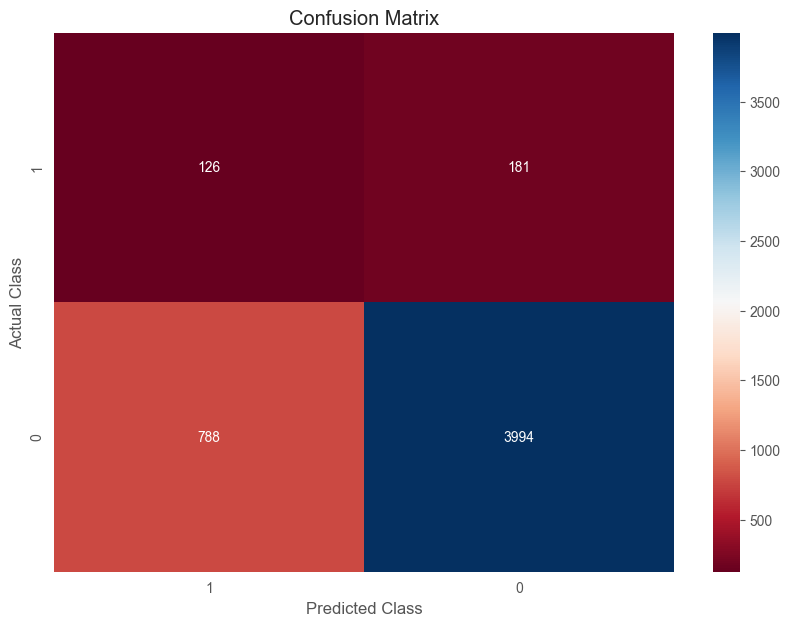

              precision    recall  f1-score   support

           0       0.96      0.84      0.89      4782
           1       0.14      0.41      0.21       307

    accuracy                           0.81      5089
   macro avg       0.55      0.62      0.55      5089
weighted avg       0.91      0.81      0.85      5089



In [32]:
predictions = best_model3.predict(x_test[feature_selection['SVM']])

conf_matrix = confusion_matrix(y_test, predictions,labels=[1,0])

# Vẽ heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=['1', '0'], yticklabels=['1', '0'],cmap='RdBu')
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()
evaluate_result['SVM']=classification_report(y_test, predictions)
print(classification_report(y_test, predictions))

#### Tuning Hyparameter

In [33]:
for x,y in evaluate_result.items():
    print(x)
    print(y)

RD
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      4782
           1       0.19      0.45      0.27       307

    accuracy                           0.85      5089
   macro avg       0.58      0.66      0.59      5089
weighted avg       0.91      0.85      0.88      5089

BG
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      4782
           1       0.14      0.43      0.21       307

    accuracy                           0.80      5089
   macro avg       0.55      0.63      0.55      5089
weighted avg       0.91      0.80      0.85      5089

SVM
              precision    recall  f1-score   support

           0       0.96      0.84      0.89      4782
           1       0.14      0.41      0.21       307

    accuracy                           0.81      5089
   macro avg       0.55      0.62      0.55      5089
weighted avg       0.91      0.81      0.85      5089



In [34]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


grid_search_rf  = GridSearchCV(estimator=RandomForestClassifier(class_weight= 'balanced', random_state=seed),
                              param_grid=param_grid_rf,
                              scoring='f1',
                              cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(x_train[feature_selection['RD']], y_train)
rf_model = grid_search_rf.best_estimator_

dump(rf_model, f'{save_dir}/rf_model.joblib')

print("Best Random Forest Hyperparameters:")
print(grid_search_rf.best_params_)


Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Best Random Forest Hyperparameters:
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


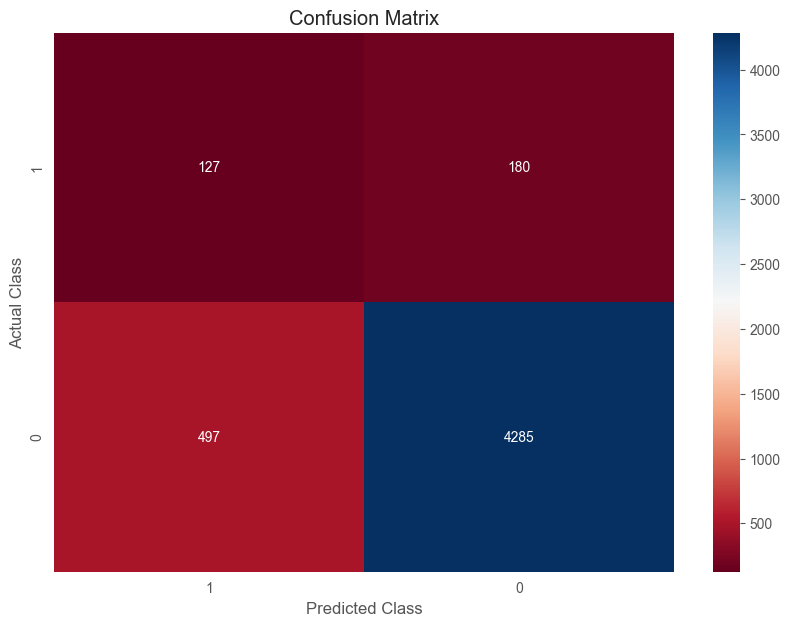

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      4782
           1       0.20      0.41      0.27       307

    accuracy                           0.87      5089
   macro avg       0.58      0.65      0.60      5089
weighted avg       0.91      0.87      0.89      5089



In [35]:
predictions = rf_model.predict(x_test[feature_selection['RD']])

conf_matrix = confusion_matrix(y_test, predictions,labels=[1,0])

# Vẽ heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=['1', '0'], yticklabels=['1', '0'],cmap='RdBu')
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()
evaluate_result['RD']=classification_report(y_test, predictions)
print(classification_report(y_test, predictions))

In [36]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [1, 3, 5],
    'subsample': [0.8, 1.0], 
    'min_samples_split': [2, 5, 10]
}


grid_search_gb  = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42),
                              param_grid=param_grid,
                              scoring='f1',
                              cv=5, n_jobs=-1, verbose=2)
grid_search_gb.fit(x_train[feature_selection['BG']], y_train)
bg_model = grid_search_gb.best_estimator_

dump(bg_model, f'{save_dir}/bg_model.joblib')

print("Best Decision Tree Hyperparameters:")
print(grid_search_gb.best_params_)


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Decision Tree Hyperparameters:
{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 0.8}


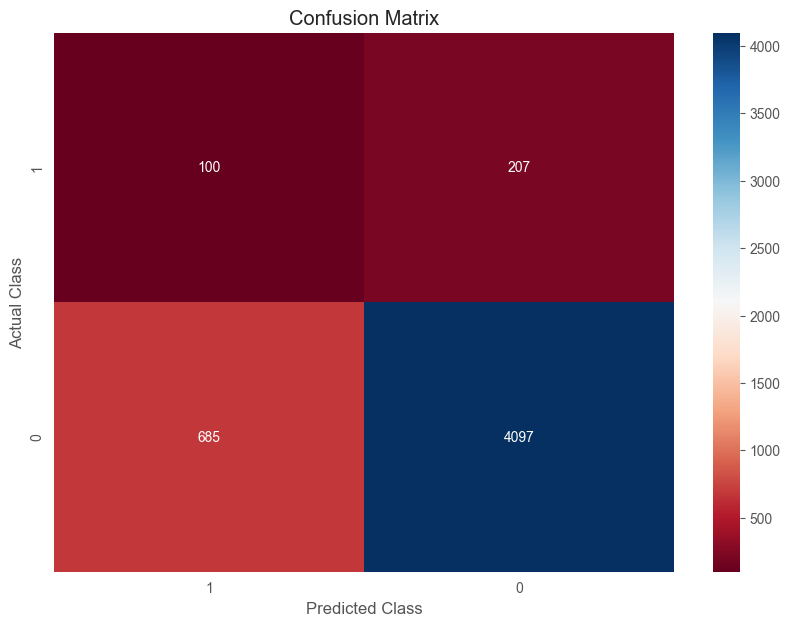

              precision    recall  f1-score   support

           0       0.95      0.86      0.90      4782
           1       0.13      0.33      0.18       307

    accuracy                           0.82      5089
   macro avg       0.54      0.59      0.54      5089
weighted avg       0.90      0.82      0.86      5089



In [37]:
predictions = bg_model.predict(x_test[feature_selection['BG']])

conf_matrix = confusion_matrix(y_test, predictions,labels=[1,0])

# Vẽ heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=['1', '0'], yticklabels=['1', '0'],cmap='RdBu')
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()
evaluate_result['BG']=classification_report(y_test, predictions)
print(classification_report(y_test, predictions))

In [38]:


param_grid_svc = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto'],
}



grid_search_svm  = GridSearchCV(estimator=SVC(kernel='rbf',class_weight= 'balanced', random_state=seed),
                              param_grid=param_grid_svc,
                              scoring='f1',
                              cv=5, n_jobs=-1, verbose=2)
grid_search_svm .fit(x_train[feature_selection['SVM']], y_train)
svm_model = grid_search_svm .best_estimator_

dump(svm_model, f'{save_dir}/svm_model.joblib')

print("Best SVM Hyperparameters:")
print(grid_search_svm .best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best SVM Hyperparameters:
{'C': 100, 'gamma': 'auto'}


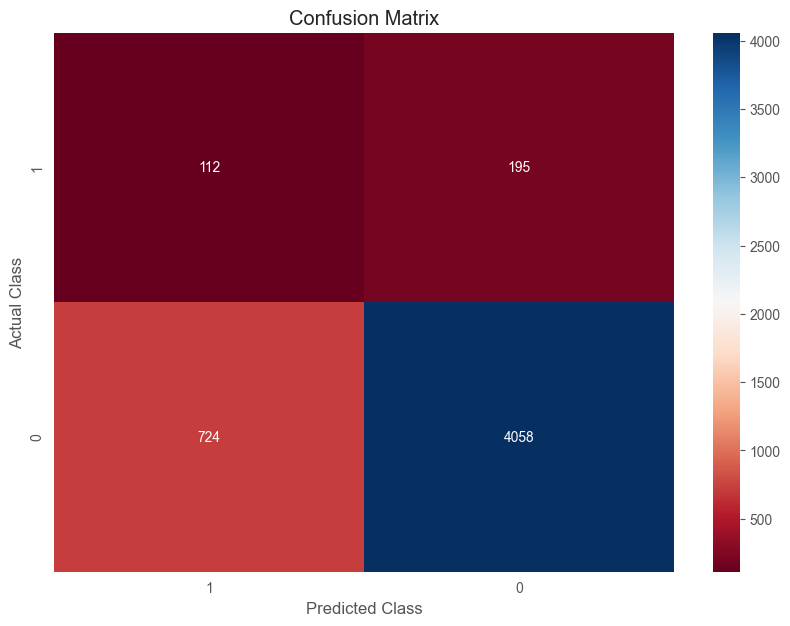

              precision    recall  f1-score   support

           0       0.95      0.85      0.90      4782
           1       0.13      0.36      0.20       307

    accuracy                           0.82      5089
   macro avg       0.54      0.61      0.55      5089
weighted avg       0.90      0.82      0.86      5089



In [39]:
predictions = svm_model.predict(x_test[feature_selection['SVM']])

conf_matrix = confusion_matrix(y_test, predictions,labels=[1,0])

# Vẽ heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=['1', '0'], yticklabels=['1', '0'],cmap='RdBu')
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()
evaluate_result['SVM']=classification_report(y_test, predictions)
print(classification_report(y_test, predictions))

In [40]:
def check_result(prediction):
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [41]:
def check_output(stt,model, X_test, Y_test):
    print(f"Lần thứ {stt}: ")
    indx = rd.randint(0, X_test.shape[0] - 1)  # Đảm bảo indx nằm trong giới hạn của DataFrame
    sample = X_test.iloc[indx, :].values        # Chuyển DataFrame thành mảng NumPy
    sample = np.expand_dims(sample, axis=0)     # Mở rộng kích thước cho phù hợp với mô hình
    y_predict = model.predict(sample)
    Y_check = check_result(Y_test.iloc[indx])
    print('True:', Y_check)
    print('Predicted:', check_result(y_predict))
    print("----------------------------")
    if Y_check==check_result(y_predict):
        return True
    else: return False
    
    

In [42]:
n_check=10
solandung=0
for i in range(n_check):
    if check_output(i+1,best_model1, x_test[feature_selection['RD']], y_test):
        solandung+=1


Lần thứ 1: 
True: N
Predicted: N
----------------------------
Lần thứ 2: 
True: N
Predicted: N
----------------------------
Lần thứ 3: 
True: N
Predicted: N
----------------------------
Lần thứ 4: 
True: N
Predicted: N
----------------------------
Lần thứ 5: 
True: N
Predicted: N
----------------------------
Lần thứ 6: 
True: N
Predicted: N
----------------------------
Lần thứ 7: 
True: N
Predicted: Y
----------------------------
Lần thứ 8: 
True: N
Predicted: N
----------------------------
Lần thứ 9: 
True: N
Predicted: Y
----------------------------
Lần thứ 10: 
True: N
Predicted: N
----------------------------


In [43]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/n_check)*100}% tổng lần dự đoán")

Số lần dự đoán đúng: 8 chiếm khoảng 80.0% tổng lần dự đoán


In [44]:
solandung=0
hopdonggianlan=0
for indx in range(len(x_test)):
    sample = x_test[feature_selection['RD']].iloc[indx, :].values        # Chuyển DataFrame thành mảng NumPy
    sample = np.expand_dims(sample, axis=0)     # Mở rộng kích thước cho phù hợp với mô hình
    y_predict = best_model1.predict(sample)
    Y_check = check_result(y_test.iloc[indx])
    print('True:', Y_check)
    print('Predicted:', check_result(y_predict))
    print("----------------------------")
    if Y_check==check_result(y_predict):
        solandung+=1
        if Y_check=='Y':
            hopdonggianlan+=1
    


True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: Y
----------------------------
True: N
Predicted: Y
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: Y
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: Y
----------------------------
True: N
Predicted: N
----------------------------


In [45]:
print(f"Số lần dự đoán đúng trong lan kiểm tra: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} lần, chiếm khoảng {(hopdonggianlan/len(y_test[y_test['FraudFound_P']==1]))*100}% số hợp đồng gian lận trong thực tế")


Số lần dự đoán đúng trong lan kiểm tra: 4342 chiếm khoảng 85.32128119473374% tổng lần dự đoán
Số hợp đồng gian lận trong lần kiểm tra: 138 lần, chiếm khoảng 44.951140065146575% số hợp đồng gian lận trong thực tế
